In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from pprint import pprint
from math import ceil
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print("TF version : ", tf.__version__)
print("Keras version : ", keras.__version__)
with_cuda = tf.test.is_built_with_cuda()
with_gpu = tf.test.is_gpu_available()
print("Built with CUDA : ", with_cuda)
print("Available GPU : ", with_gpu)

if with_cuda and with_gpu:
    keras.backend.set_image_data_format('channels_first')
else: 
    keras.backend.set_image_data_format('channels_last')

print("keras data_format : ", keras.backend.image_data_format())

TF version :  1.10.0
Keras version :  2.1.6-tf
Built with CUDA :  True
Available GPU :  True
keras data_format :  channels_first


In [4]:
BATCH_SIZE = 128
EPOCHS = 200
INIT_LR = 0.1

In [5]:
print("... loading CIFAR10 dataset ...")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

x_train, y_train = shuffle(x_train, y_train, random_state=51)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=51)
# cast samples and labels
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = keras.utils.to_categorical(y_train.astype(np.int32), num_classes=10)
y_val = keras.utils.to_categorical(y_val.astype(np.int32), num_classes=10)
y_test = keras.utils.to_categorical(y_test.astype(np.int32), num_classes=10)

print("\tTRAIN - images {} | {}  - labels {} - {}".format(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype))
print("\tVAL - images {} | {}  - labels {} - {}".format(x_val.shape, x_val.dtype, y_val.shape, y_val.dtype))
print("\tTEST - images {} | {}  - labels {} - {}\n".format(x_test.shape, x_test.dtype, y_test.shape, y_test.dtype))

... loading CIFAR10 dataset ...
	TRAIN - images (40000, 3, 32, 32) | float32  - labels (40000, 10) - float32
	VAL - images (10000, 3, 32, 32) | float32  - labels (10000, 10) - float32
	TEST - images (10000, 3, 32, 32) | float32  - labels (10000, 10) - float32



In [6]:
generator_aug = keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                             samplewise_std_normalization=True,
                                                             width_shift_range=5,
                                                             height_shift_range=5,
                                                             fill_mode='constant',
                                                             cval=0.0,
                                                             horizontal_flip=True,
                                                             vertical_flip=False,
                                                             data_format=keras.backend.image_data_format())

generator = keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                         samplewise_std_normalization=True,
                                                         data_format=keras.backend.image_data_format())

# python iterator object that yields augmented samples 
iterator_train_aug = generator_aug.flow(x_train, y_train, batch_size=BATCH_SIZE)

# python iterators object that yields not augmented samples 
iterator_train = generator.flow(x_train, y_train, batch_size=BATCH_SIZE)
iterator_valid = generator.flow(x_val, y_val, batch_size=BATCH_SIZE)
iterator_test = generator.flow(x_test, y_test, batch_size=BATCH_SIZE)

steps_per_epoch_train = int(ceil(iterator_train.n/BATCH_SIZE))
steps_per_epoch_val = int(ceil(iterator_valid.n/BATCH_SIZE))
steps_per_epoch_test = int(ceil(iterator_test.n/BATCH_SIZE))

In [7]:
# test iterator with data augmentation
x, y = iterator_train_aug.next()

print("x : {} | {}".format(x.shape, x.dtype))
print("y : {} | {}".format(y.shape, y.dtype))

x : (128, 3, 32, 32) | float32
y : (128, 10) | float32


# Build Keras model

In [8]:
from resnet import ResNet56

In [9]:
shape = [3, 32, 32] if keras.backend.image_data_format()=='channels_first' else [32, 32, 3]
model = ResNet56(input_shape=shape, classes=10, activation='relu-dropout', rate=0.4).build_model()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 30, 30)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 30, 30)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16, 30, 30)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
activation

In [11]:
optimizer = keras.optimizers.SGD(lr=INIT_LR, momentum=0.9)
loss = 'categorical_crossentropy'
metrics = ['acc', ]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
#model.save_weights('random_weights.h5')
model.load_weights('random_weights.h5')

# Train model

In [13]:
callbacks = []

model_ckpt = keras.callbacks.ModelCheckpoint("model_ckpt_dropactivation_best_relu-dropout.h5",
                                             monitor='val_acc', verbose=1, save_best_only=True, 
                                             save_weights_only=True)
callbacks.append(model_ckpt)

def schedule(epoch):
    if epoch < 91:
        return INIT_LR
    if epoch < 136:
        return 0.1*INIT_LR
    if epoch < 182:
        return 0.01*INIT_LR
    else:
        return 0.001*INIT_LR
    
lr_schedule = keras.callbacks.LearningRateScheduler(schedule, verbose=1)
callbacks.append(lr_schedule)

In [14]:
%%time

history = model.fit_generator(iterator_train_aug, 
                              steps_per_epoch=steps_per_epoch_train,
                              epochs=EPOCHS,
                              verbose=1,
                              validation_data=iterator_valid,
                              validation_steps=steps_per_epoch_val,
                              callbacks=callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/200
312/313 [============================>.] - ETA: 0s - loss: 2.6256 - acc: 0.2977
Epoch 00001: val_acc improved from -inf to 0.16740, saving model to model_ckpt_dropactivation_best_relu-dropout.h5
313/313 [==============================] - 50s 159ms/step - loss: 2.6250 - acc: 0.2979 - val_loss: 5.5074 - val_acc: 0.1674

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/200
312/313 [============================>.] - ETA: 0s - loss: 2.1427 - acc: 0.4362
Epoch 00002: val_acc improved from 0.16740 to 0.41790, saving model to model_ckpt_dropactivation_best_relu-dropout.h5
313/313 [==============================] - 31s 98ms/step - loss: 2.1424 - acc: 0.4363 - val_loss: 2.1714 - val_acc: 0.4179

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/200
312/313 [============================>.] - ETA: 0s - loss: 1.8456 - acc: 0.5135
Epoch 00003: val_acc did not improve from 0


Epoch 00024: LearningRateScheduler reducing learning rate to 0.1.
Epoch 24/200
312/313 [============================>.] - ETA: 0s - loss: 0.9634 - acc: 0.7632
Epoch 00024: val_acc did not improve from 0.73990
313/313 [==============================] - 31s 99ms/step - loss: 0.9635 - acc: 0.7632 - val_loss: 1.0662 - val_acc: 0.7361

Epoch 00025: LearningRateScheduler reducing learning rate to 0.1.
Epoch 25/200
312/313 [============================>.] - ETA: 0s - loss: 0.9660 - acc: 0.7629
Epoch 00025: val_acc improved from 0.73990 to 0.74620, saving model to model_ckpt_dropactivation_best_relu-dropout.h5
313/313 [==============================] - 31s 100ms/step - loss: 0.9663 - acc: 0.7628 - val_loss: 1.0660 - val_acc: 0.7462

Epoch 00026: LearningRateScheduler reducing learning rate to 0.1.
Epoch 26/200
312/313 [============================>.] - ETA: 0s - loss: 0.9550 - acc: 0.7685
Epoch 00026: val_acc did not improve from 0.74620
313/313 [==============================] - 31s 100ms/st

312/313 [============================>.] - ETA: 0s - loss: 0.9343 - acc: 0.7926
Epoch 00048: val_acc did not improve from 0.78580
313/313 [==============================] - 30s 97ms/step - loss: 0.9348 - acc: 0.7924 - val_loss: 1.0789 - val_acc: 0.7509

Epoch 00049: LearningRateScheduler reducing learning rate to 0.1.
Epoch 49/200
312/313 [============================>.] - ETA: 0s - loss: 0.9349 - acc: 0.7923
Epoch 00049: val_acc improved from 0.78580 to 0.81280, saving model to model_ckpt_dropactivation_best_relu-dropout.h5
313/313 [==============================] - 31s 98ms/step - loss: 0.9350 - acc: 0.7923 - val_loss: 0.8910 - val_acc: 0.8128

Epoch 00050: LearningRateScheduler reducing learning rate to 0.1.
Epoch 50/200
312/313 [============================>.] - ETA: 0s - loss: 0.9371 - acc: 0.7931
Epoch 00050: val_acc did not improve from 0.81280
313/313 [==============================] - 30s 97ms/step - loss: 0.9375 - acc: 0.7929 - val_loss: 1.1762 - val_acc: 0.7416

Epoch 00051:


Epoch 00073: LearningRateScheduler reducing learning rate to 0.1.
Epoch 73/200
312/313 [============================>.] - ETA: 0s - loss: 0.9222 - acc: 0.8026
Epoch 00073: val_acc did not improve from 0.81280
313/313 [==============================] - 30s 97ms/step - loss: 0.9221 - acc: 0.8027 - val_loss: 0.9406 - val_acc: 0.8091

Epoch 00074: LearningRateScheduler reducing learning rate to 0.1.
Epoch 74/200
312/313 [============================>.] - ETA: 0s - loss: 0.9306 - acc: 0.7995
Epoch 00074: val_acc did not improve from 0.81280
313/313 [==============================] - 30s 97ms/step - loss: 0.9311 - acc: 0.7994 - val_loss: 1.0364 - val_acc: 0.7758

Epoch 00075: LearningRateScheduler reducing learning rate to 0.1.
Epoch 75/200
312/313 [============================>.] - ETA: 0s - loss: 0.9267 - acc: 0.8003
Epoch 00075: val_acc did not improve from 0.81280
313/313 [==============================] - 30s 97ms/step - loss: 0.9266 - acc: 0.8003 - val_loss: 1.0400 - val_acc: 0.7750




Epoch 00097: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 97/200
312/313 [============================>.] - ETA: 0s - loss: 0.6963 - acc: 0.8695
Epoch 00097: val_acc did not improve from 0.87920
313/313 [==============================] - 30s 97ms/step - loss: 0.6964 - acc: 0.8695 - val_loss: 0.7009 - val_acc: 0.8757

Epoch 00098: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 98/200
312/313 [============================>.] - ETA: 0s - loss: 0.6887 - acc: 0.8687
Epoch 00098: val_acc did not improve from 0.87920
313/313 [==============================] - 30s 97ms/step - loss: 0.6885 - acc: 0.8687 - val_loss: 0.7131 - val_acc: 0.8675

Epoch 00099: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 99/200
312/313 [============================>.] - ETA: 0s - loss: 0.6739 - acc: 0.8737
Epoch 00099: val_acc did not improve from 0.87920
313/313 [==============================] - 30s 97ms/step - loss: 0.6734 -


Epoch 00120: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 120/200
312/313 [============================>.] - ETA: 0s - loss: 0.5302 - acc: 0.8891
Epoch 00120: val_acc improved from 0.88580 to 0.88960, saving model to model_ckpt_dropactivation_best_relu-dropout.h5
313/313 [==============================] - 31s 98ms/step - loss: 0.5300 - acc: 0.8891 - val_loss: 0.5730 - val_acc: 0.8896

Epoch 00121: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 121/200
312/313 [============================>.] - ETA: 0s - loss: 0.5216 - acc: 0.8930
Epoch 00121: val_acc did not improve from 0.88960
313/313 [==============================] - 30s 97ms/step - loss: 0.5221 - acc: 0.8929 - val_loss: 0.5694 - val_acc: 0.8880

Epoch 00122: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 122/200
312/313 [============================>.] - ETA: 0s - loss: 0.5246 - acc: 0.8892
Epoch 00122: val_acc improved from 0.88960 to 0.8922

312/313 [============================>.] - ETA: 0s - loss: 0.4355 - acc: 0.9108
Epoch 00143: val_acc did not improve from 0.89390
313/313 [==============================] - 30s 97ms/step - loss: 0.4355 - acc: 0.9108 - val_loss: 0.5444 - val_acc: 0.8909

Epoch 00144: LearningRateScheduler reducing learning rate to 0.001.
Epoch 144/200
312/313 [============================>.] - ETA: 0s - loss: 0.4346 - acc: 0.9104
Epoch 00144: val_acc did not improve from 0.89390
313/313 [==============================] - 30s 97ms/step - loss: 0.4347 - acc: 0.9103 - val_loss: 0.5324 - val_acc: 0.8931

Epoch 00145: LearningRateScheduler reducing learning rate to 0.001.
Epoch 145/200
312/313 [============================>.] - ETA: 0s - loss: 0.4300 - acc: 0.9133
Epoch 00145: val_acc did not improve from 0.89390
313/313 [==============================] - 30s 97ms/step - loss: 0.4297 - acc: 0.9134 - val_loss: 0.5325 - val_acc: 0.8930

Epoch 00146: LearningRateScheduler reducing learning rate to 0.001.
Epoch 


Epoch 00167: LearningRateScheduler reducing learning rate to 0.001.
Epoch 167/200
312/313 [============================>.] - ETA: 0s - loss: 0.4059 - acc: 0.9168
Epoch 00167: val_acc did not improve from 0.89850
313/313 [==============================] - 30s 97ms/step - loss: 0.4059 - acc: 0.9167 - val_loss: 0.5247 - val_acc: 0.8941

Epoch 00168: LearningRateScheduler reducing learning rate to 0.001.
Epoch 168/200
312/313 [============================>.] - ETA: 0s - loss: 0.4056 - acc: 0.9175
Epoch 00168: val_acc did not improve from 0.89850
313/313 [==============================] - 30s 97ms/step - loss: 0.4057 - acc: 0.9175 - val_loss: 0.5201 - val_acc: 0.8965

Epoch 00169: LearningRateScheduler reducing learning rate to 0.001.
Epoch 169/200
312/313 [============================>.] - ETA: 0s - loss: 0.4027 - acc: 0.9190
Epoch 00169: val_acc improved from 0.89850 to 0.90010, saving model to model_ckpt_dropactivation_best_relu-dropout.h5
313/313 [==============================] - 31s 


Epoch 00191: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 191/200
312/313 [============================>.] - ETA: 0s - loss: 0.3906 - acc: 0.9221
Epoch 00191: val_acc did not improve from 0.90040
313/313 [==============================] - 30s 97ms/step - loss: 0.3904 - acc: 0.9221 - val_loss: 0.5130 - val_acc: 0.8994

Epoch 00192: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 192/200
312/313 [============================>.] - ETA: 0s - loss: 0.3915 - acc: 0.9207
Epoch 00192: val_acc did not improve from 0.90040
313/313 [==============================] - 30s 97ms/step - loss: 0.3913 - acc: 0.9207 - val_loss: 0.5126 - val_acc: 0.8998

Epoch 00193: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 193/200
312/313 [============================>.] - ETA: 0s - loss: 0.3863 - acc: 0.9222
Epoch 00193: val_acc did not improve from 0.90040
313/313 [==============================] - 30s 97ms/step - loss: 0.3862 - acc: 0.9222 - val_loss: 0.5134 - val_a

In [15]:
import pickle
with open('relu-dropout-history.dict', 'wb') as f:
    pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
hist_dict = history.history
print(list(hist_dict.keys()))

['loss', 'val_loss', 'val_acc', 'acc']


In [17]:
# load best model
model.load_weights('model_ckpt_dropactivation_best_relu-dropout.h5')

In [18]:
best_epoch = np.argmax(hist_dict['val_acc'])
print("best epoch : {}  |  {}".format(best_epoch, hist_dict['val_acc'][best_epoch]))

best epoch : 188  |  0.9004


In [19]:
loss_test, acc_test = model.evaluate_generator(generator=iterator_test, steps=steps_per_epoch_test, verbose=1)
print("ACC (test) : ", acc_test)
print("LOSS (test) : ", loss_test)

79/79 [==============================] - 1s 18ms/step
ACC (test) :  0.8992
LOSS (test) :  0.5142434755563736


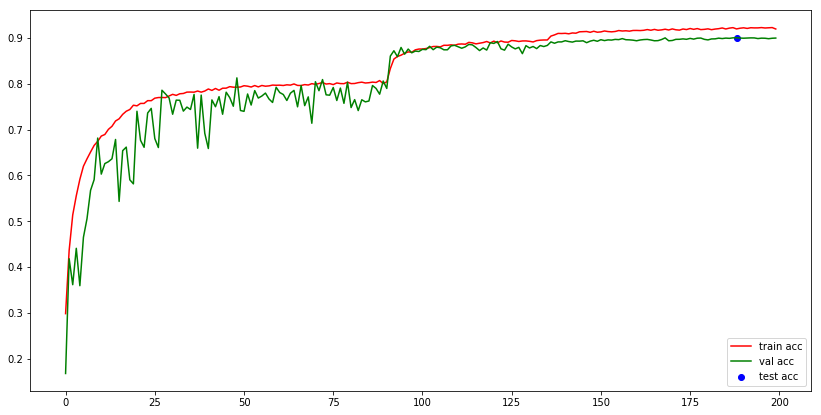

In [20]:
plt.figure(figsize=(14,7))
plt.plot(list(range(EPOCHS)), hist_dict['acc'], color='red', label='train acc')
plt.plot(list(range(EPOCHS)), hist_dict['val_acc'], color='green', label='val acc')
plt.scatter([best_epoch, ], [acc_test, ], color='blue', label='test acc')
plt.legend(loc='lower right')

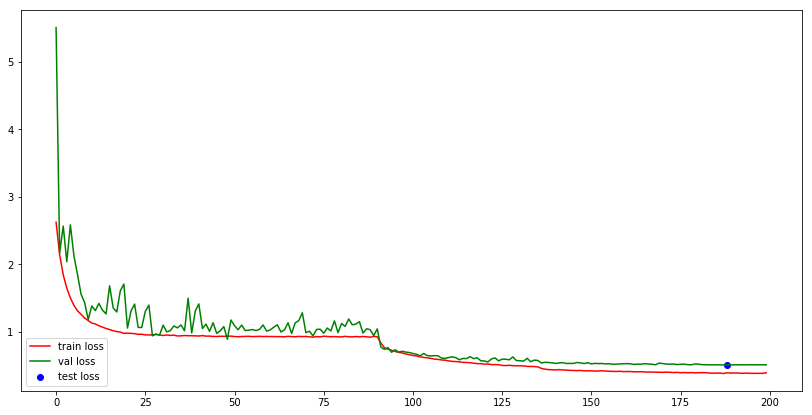

In [21]:
plt.figure(figsize=(14,7))
plt.plot(list(range(EPOCHS)), hist_dict['loss'], color='red', label='train loss')
plt.plot(list(range(EPOCHS)), hist_dict['val_loss'], color='green', label='val loss')
plt.scatter([best_epoch, ], [loss_test, ], color='blue', label='test loss')
plt.legend(loc='lower left')